In [67]:
 import sys
sys.path.insert(0,'../src')
sys.path.insert(0,'../data')
sys.path.insert(0,'../upload_data')
sys.path.insert(0,'../config')
sys.path.insert(0,'..')
import geopandas as gpd
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import etl
import json
import cleaning
import datetime
from heatmaps import *
import matplotlib.colors as colors

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%reload_ext autoreload

In [14]:
fp_2017 = '../data/raw/STOPS_2017.csv'
test_2017 = cleaning.clean_2014_2017(fp_2017)
test_2017.head()

,stop_id,stop_cause,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized
0,1444799,Moving Violation,120,Native American,Male,37.0,2017-01-01,00:03:00,N,N,NaN,N,N
1,1444821,Equipment Violation,520,White,Male,22.0,2017-01-01,00:25:00,N,N,NaN,N,N
2,1447102,Moving Violation,520,White,Male,29.0,2017-01-01,01:45:00,N,N,NaN,N,N
3,1444801,Equipment Violation,720,Hispanic/Latino/a,Female,61.0,2017-01-01,03:10:00,N,N,NaN,N,N
4,1444802,Equipment Violation,120,Hispanic/Latino/a,Male,24.0,2017-01-01,03:30:00,N,N,NaN,N,N


In [15]:
fp_2018 = '../data/raw/STOPS_2018-2019.csv'
test_2018 = cleaning.clean_2018_2019(fp_2018)
test_2018.head()

,stop_id,stop_cause,beat,service_area,subject_race,subject_sex,subject_age,date_stop,time_stop,arrested,searched,obtained_consent,contraband_found,property_seized
0,2443,Reasonable Suspicion,122,120,White,Male,25,2018-07-01,00:01:37,Y,N,NaN,N,N
1,2444,Traffic Violation,121,120,White,Male,25,2018-07-01,00:03:34,N,N,NaN,N,N
2,2447,Reasonable Suspicion,822,820,Hispanic/Latino/a,Male,30,2018-07-01,00:05:43,N,N,NaN,N,N
3,2448,Traffic Violation,614,610,White,Male,23,2018-07-01,00:19:06,N,N,NaN,N,N
4,2449,Reasonable Suspicion,115,110,White,Male,25,2018-07-01,00:03:00,Y,Y,NaN,N,N


In [10]:
areas = make_areas()
areas

,serv,geometry
0,930,"MULTIPOLYGON (((6268975.465 1931147.469, 62689..."
1,0,"MULTIPOLYGON (((6261648.576 1836846.672, 62616..."
2,510,"MULTIPOLYGON (((6261640.429 1836823.561, 62616..."
3,720,"POLYGON ((6302781.000 1793246.001, 6302905.000..."
4,310,"POLYGON ((6284667.652 1874418.895, 6284694.392..."
...,...,...
135,240,"POLYGON ((6295777.084 1908435.558, 6295790.126..."
136,930,"POLYGON ((6295209.132 1952772.422, 6295208.647..."
137,930,"POLYGON ((6287497.113 1936631.116, 6287462.453..."
138,230,"POLYGON ((6306176.245 1943421.146, 6306158.416..."


In [16]:
make_proportions(test,'Asian','2018-07-01','2018-10-15')

,prop
service_area,
110,0.389007
120,0.408492
230,0.311028
240,0.435225
310,0.734200
320,0.577301
430,0.288547
440,0.438810
510,0.318795


In [29]:
from dateutil.relativedelta import relativedelta

In [33]:
def make_heat(df,race,event,start_date,end_date):
    areas = make_areas()
    props = make_proportions(df,race,start_date,end_date)
    heat = areas.merge(props, left_on='serv',right_index=True, how='outer')
    heat = heat.dissolve(by='serv',aggfunc='first').fillna(0).drop(0)
    event_y = (datetime.date.fromisoformat(start_date) + relativedelta(months = 2)).year
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.axis('off')
    ax.set_title(f'Proportion of {race} Drivers Stopped By Service Area\n Event: {event} ({event_y})'.format(race,event,event_y), fontdict={'fontsize':'15','fontweight' : '3'})
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=heat.prop.max()))
    fig.colorbar(sm)
    heat.plot(column='prop', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

2018

In [68]:
cdict = {'red':  ((0.0, 0.0, 0.0),   # no red at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.8, 0.8)),  # set to 0.8 so its not too bright at 1

        'green': ((0.0, 0.8, 0.8),   # set to 0.8 so its not too bright at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0)),  # no green at 1

        'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0))   # no blue at 1
       }

# Create the colormap using the dictionary
GnRd = colors.LinearSegmentedColormap('GnRd', cdict)

In [90]:
def make_difference_heatmap(df_current,df_prior,race,event,start_date,end_date):
    areas = make_areas()
    prior_start_date = (datetime.date.fromisoformat(start_date)-relativedelta(years=1)).isoformat()
    prior_end_date = (datetime.date.fromisoformat(end_date)-relativedelta(years=1)).isoformat()
    props_post = make_proportions(df_current,race,start_date,end_date)
    props_pre = make_proportions(df_prior,race,prior_start_date,prior_end_date)
    differences = props_post.subtract(props_pre)
    heat_diff = areas.merge(differences, left_on='serv',right_index=True, how='outer')
    heat_diff = heat_diff.dissolve(by='serv',aggfunc='first').fillna(0).drop(0)
    event_y = (datetime.date.fromisoformat(start_date) + relativedelta(months = 2)).year
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.axis('off')
    ax.set_title(f'Proportion of {race} Drivers Stopped By Service Area\n Event: {event} ({event_y})'.format(race,event,event_y), fontdict={'fontsize':'15','fontweight' : '3'})
    sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=-1, vmax=1))
    fig.colorbar(sm)
    heat_diff.plot(column='prop', cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='0.8')
    return heat_diff


,geometry,prop
serv,,
110,"POLYGON ((6279253.112 1884255.837, 6279262.023...",-0.112626
120,"POLYGON ((6252987.541 1857451.641, 6252282.413...",0.019834
230,"POLYGON ((6305786.455 1931764.390, 6305786.467...",-0.208803
240,"POLYGON ((6291971.520 1887674.568, 6291757.788...",-0.172780
310,"POLYGON ((6296145.895 1867575.086, 6296105.935...",-0.076739
320,"POLYGON ((6316141.200 1862937.460, 6316142.727...",-0.127995
430,"POLYGON ((6317292.625 1824640.012, 6317192.369...",-0.029056
440,"POLYGON ((6299388.999 1831529.000, 6299388.000...",0.078146
510,"MULTIPOLYGON (((6266866.000 1831771.472, 62668...",-0.295540


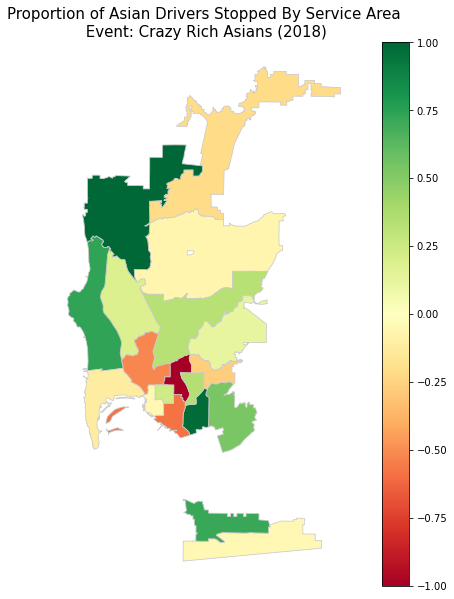

In [91]:
make_difference_heatmap(test_2018,test_2017,'Asian','Crazy Rich Asians','2018-07-01','2018-10-15')

,geometry,prop
serv,,
110,"POLYGON ((6279253.112 1884255.837, 6279262.023...",-0.112626
120,"POLYGON ((6252987.541 1857451.641, 6252282.413...",0.019834
230,"POLYGON ((6305786.455 1931764.390, 6305786.467...",-0.208803
240,"POLYGON ((6291971.520 1887674.568, 6291757.788...",-0.172780
310,"POLYGON ((6296145.895 1867575.086, 6296105.935...",-0.076739
320,"POLYGON ((6316141.200 1862937.460, 6316142.727...",-0.127995
430,"POLYGON ((6317292.625 1824640.012, 6317192.369...",-0.029056
440,"POLYGON ((6299388.999 1831529.000, 6299388.000...",0.078146
510,"MULTIPOLYGON (((6266866.000 1831771.472, 62668...",-0.295540


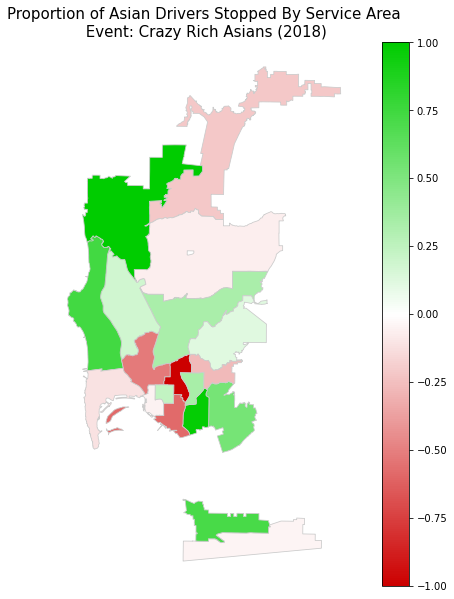

In [94]:
heatmaps.make_difference_heatmap(test_2018,test_2017,'Asian','Crazy Rich Asians','2018-07-01','2018-10-15')

(None, None)

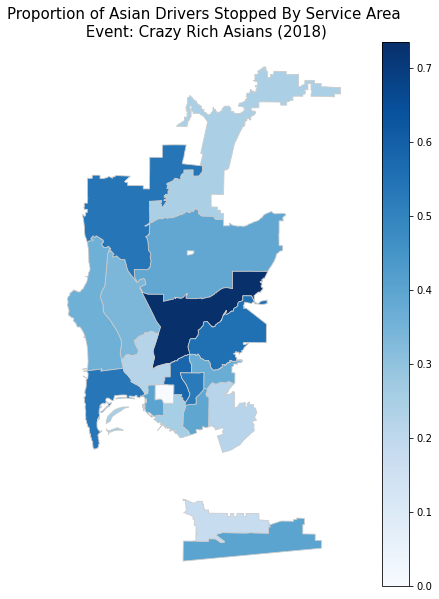

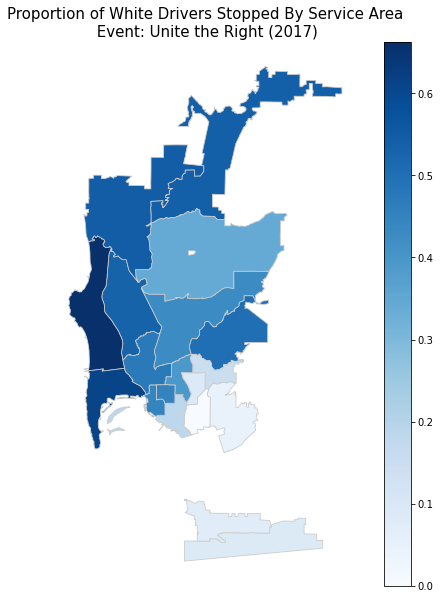

In [35]:
(heatmaps.make_heat(test_2018,'Asian','Crazy Rich Asians','2018-07-01','2018-10-15'),heatmaps.make_heat(test_2017,'White','Unite the Right','2017-06-12','2017-10-12'))

(None, None)

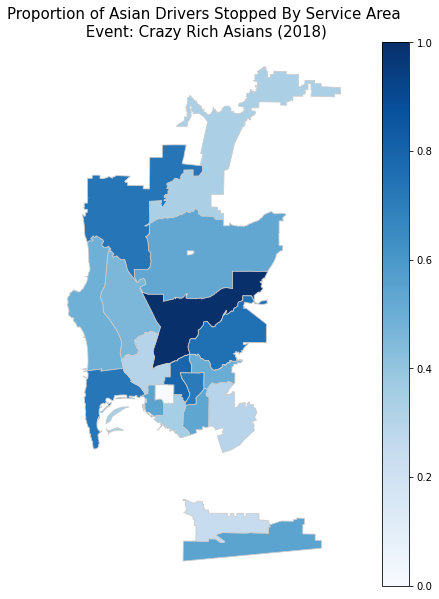

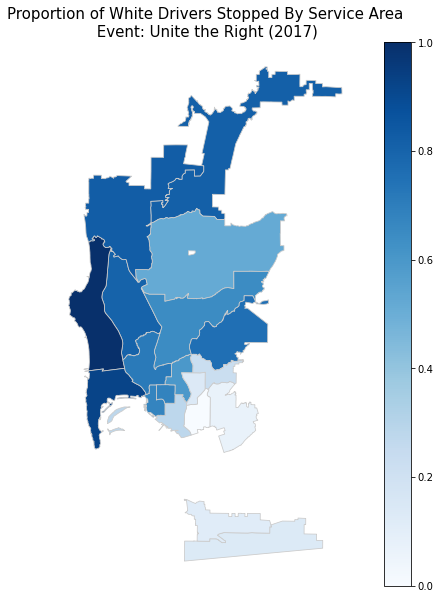

In [58]:
(heatmaps.make_heat(test_2018,'Asian','Crazy Rich Asians','2018-07-01','2018-10-15'),heatmaps.make_heat(test_2017,'White','Unite the Right','2017-06-12','2017-10-12'))